In [ ]:
!pip install numpy==1.21.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from speech_command_dataset import SpeechCommandDataset
from torchvision.transforms import Compose
import torchvision.models as models
import model

# from apex import amp

import os,time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
EPOCH = 200
BATCH_SIZE = 128
LR = 1e-2
Weight_decay = 1e-5

In [ ]:
# declare dataloader
training_params = {"batch_size": BATCH_SIZE,
                       "shuffle": True,
                       "drop_last": False,
                       "num_workers": 1}

testing_params = {"batch_size": BATCH_SIZE,
                       "shuffle": False,
                       "drop_last": False,
                       "num_workers": 1}

train_set = SpeechCommandDataset()
train_loader = DataLoader(train_set, **training_params)

test_set = SpeechCommandDataset(is_training=False)
test_loader = DataLoader(test_set, **testing_params)

In [ ]:
# declare network
net = model.SincNet_Quat().cuda()
print(net)

SincNet_Quat(
  (sincconv): _Layer(
    (conv): QuatSincConv1d(
      (w_quan): Quantize(num_of_bits=7)
    )
    (logabs): LogAbs()
    (relu): ReLU()
    (quan): Quantize(num_of_bits=8)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (features): ModuleList(
    (0): _Layer(
      (conv0): QuaternaryConv1d(32, 32, kernel_size=(25,), stride=(2,), bias=False)
      (conv1): QuaternaryConv1d(32, 32, kernel_size=(25,), stride=(2,), bias=False)
      (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (quan): Quantize(num_of_bits=4)
      (relu): ReLU()
      (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (1): _Layer(
      (conv0): QuaternaryConv1d(32, 32, kernel_size=(9,), stride=(1,), bias=False)
      (conv1): QuaternaryConv1d(32, 64, kernel_size=(9,), stride=(1,), bias=False)
      (bn): BatchNorm1d(64, eps

In [ ]:
# declare optimizer and loss function
optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=Weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,  patience=15, verbose=True, eps=1e-09)

loss_func = nn.CrossEntropyLoss()

In [ ]:
print('Begin training...')

best_accuracy = 0
itertion = 0
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
lr_list = []

for epoch in range(EPOCH):
    net.train()
    start_time = time.time()
    total_train_loss = 0
    total_dloss = 0
    correct = 0
    total = 0
    batch_num = 0

    for step, (audios, labels) in enumerate(train_loader):
        audios = audios.cuda()
        labels = labels.cuda()
        outputs = net(audios)

        loss = loss_func(outputs, labels)

        total_train_loss += loss.item()
        batch_num += 1
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time
    train_loss = total_train_loss / batch_num
    train_loss_list.append(train_loss)
    train_acc = 100.0 * float(correct) / float(total)
    train_acc_list.append(train_acc)

    start_time = time.time()
    total_val_loss = 0
    correct = 0
    total = 0
    batch_num = 0

    net.eval()
    for audios, labels in test_loader:
        audios = audios.cuda()
        labels = labels.cuda()

        outputs = net(audios)
        loss = loss_func(outputs, labels)

        total_val_loss += loss.item()
        batch_num += 1
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    end_time = time.time()
    test_time = end_time-start_time
    val_loss = total_val_loss / batch_num
    val_loss_list.append(val_loss)
    val_acc = 100.0 * float(correct) / float(total)
    val_acc_list.append(val_acc)

    for param_group in optimizer.param_groups:
        lr_list.append(param_group['lr'])


    print(time.strftime("%d %b %Y %H:%M:%S", time.localtime()))
    print('Epoch: %3d' % epoch, '|train loss: %.4f' % train_loss, '|train accuracy: %.2f' % train_acc,
          '|validation loss: %.4f' % val_loss, '|validation accuracy: %.2f' % val_acc,
          '|learning rate: %.1e' % lr_list[-1],
          '|train time: %.2f' % train_time,'|test time: %.2f' % test_time)


    scheduler.step(val_loss)



    if val_acc>best_accuracy:
        print('Saving..')
        torch.save({'cfg': None, 'state_dict': net.state_dict()}, os.path.join('./Checkpoint', 'SincNet_best.pth.tar'))
        best_accuracy = val_acc


print('Best accuracy: %.2f' % best_accuracy)

Begin training...
22 Aug 2023 13:39:14
Epoch:   0 |train loss: 1.4976 |train accuracy: 50.63 |validation loss: 1.7907 |validation accuracy: 41.58 |learning rate: 1.0e-02 |train time: 37.90 |test time: 9.84
Saving..
22 Aug 2023 13:39:50
Epoch:   1 |train loss: 1.0030 |train accuracy: 67.78 |validation loss: 0.9418 |validation accuracy: 68.66 |learning rate: 1.0e-02 |train time: 28.87 |test time: 6.99
Saving..
22 Aug 2023 13:40:23
Epoch:   2 |train loss: 0.8170 |train accuracy: 73.70 |validation loss: 1.3075 |validation accuracy: 58.78 |learning rate: 1.0e-02 |train time: 28.20 |test time: 5.03
22 Aug 2023 13:40:56
Epoch:   3 |train loss: 0.7308 |train accuracy: 76.68 |validation loss: 0.7561 |validation accuracy: 76.01 |learning rate: 1.0e-02 |train time: 28.02 |test time: 5.01
Saving..
22 Aug 2023 13:41:29
Epoch:   4 |train loss: 0.6716 |train accuracy: 78.52 |validation loss: 0.6575 |validation accuracy: 78.63 |learning rate: 1.0e-02 |train time: 27.84 |test time: 5.03
Saving..
22 Aug

14 Aug 2023 10:54:00
Epoch:  87 |train loss: 0.3597 |train accuracy: 88.31 |validation loss: 0.4169 |validation accuracy: 87.27 |learning rate: 2.5e-03 |train time: 15.12 |test time: 2.42
14 Aug 2023 10:54:17
Epoch:  88 |train loss: 0.3621 |train accuracy: 88.41 |validation loss: 0.4236 |validation accuracy: 86.93 |learning rate: 2.5e-03 |train time: 15.26 |test time: 2.37
14 Aug 2023 10:54:35
Epoch:  89 |train loss: 0.3800 |train accuracy: 88.16 |validation loss: 0.4296 |validation accuracy: 86.36 |learning rate: 2.5e-03 |train time: 15.19 |test time: 2.39
14 Aug 2023 10:54:53
Epoch:  90 |train loss: 0.3722 |train accuracy: 87.93 |validation loss: 0.4132 |validation accuracy: 87.90 |learning rate: 2.5e-03 |train time: 15.51 |test time: 2.35
Saving..
14 Aug 2023 10:55:11
Epoch:  91 |train loss: 0.3640 |train accuracy: 88.10 |validation loss: 0.4087 |validation accuracy: 87.46 |learning rate: 2.5e-03 |train time: 15.52 |test time: 2.38
14 Aug 2023 10:55:28
Epoch:  92 |train loss: 0.3591

14 Aug 2023 11:08:13
Epoch: 131 |train loss: 0.3591 |train accuracy: 88.36 |validation loss: 0.4024 |validation accuracy: 87.46 |learning rate: 1.3e-03 |train time: 15.86 |test time: 2.36
14 Aug 2023 11:08:31
Epoch: 132 |train loss: 0.3556 |train accuracy: 88.37 |validation loss: 0.4065 |validation accuracy: 87.16 |learning rate: 1.3e-03 |train time: 15.56 |test time: 2.43
14 Aug 2023 11:08:49
Epoch: 133 |train loss: 0.3660 |train accuracy: 88.42 |validation loss: 0.4203 |validation accuracy: 86.86 |learning rate: 1.3e-03 |train time: 15.45 |test time: 2.36
14 Aug 2023 11:09:07
Epoch: 134 |train loss: 0.3614 |train accuracy: 88.37 |validation loss: 0.4078 |validation accuracy: 87.73 |learning rate: 1.3e-03 |train time: 15.68 |test time: 2.30
14 Aug 2023 11:09:25
Epoch: 135 |train loss: 0.3629 |train accuracy: 88.49 |validation loss: 0.4192 |validation accuracy: 86.82 |learning rate: 1.3e-03 |train time: 15.64 |test time: 2.38
14 Aug 2023 11:09:43
Epoch: 136 |train loss: 0.3543 |train a

14 Aug 2023 11:20:42
Epoch: 174 |train loss: 0.3489 |train accuracy: 88.58 |validation loss: 0.4049 |validation accuracy: 86.97 |learning rate: 3.1e-04 |train time: 15.04 |test time: 2.39
14 Aug 2023 11:20:59
Epoch: 175 |train loss: 0.3520 |train accuracy: 88.65 |validation loss: 0.4093 |validation accuracy: 87.03 |learning rate: 3.1e-04 |train time: 14.71 |test time: 2.35
14 Aug 2023 11:21:16
Epoch: 176 |train loss: 0.3478 |train accuracy: 88.72 |validation loss: 0.4006 |validation accuracy: 87.43 |learning rate: 3.1e-04 |train time: 15.03 |test time: 2.37
14 Aug 2023 11:21:34
Epoch: 177 |train loss: 0.3465 |train accuracy: 88.61 |validation loss: 0.3941 |validation accuracy: 87.50 |learning rate: 3.1e-04 |train time: 15.14 |test time: 2.33
14 Aug 2023 11:21:52
Epoch: 178 |train loss: 0.3456 |train accuracy: 88.71 |validation loss: 0.4052 |validation accuracy: 86.72 |learning rate: 3.1e-04 |train time: 16.14 |test time: 2.36
14 Aug 2023 11:22:10
Epoch: 179 |train loss: 0.3570 |train a

Text(0, 0.5, 'lr')

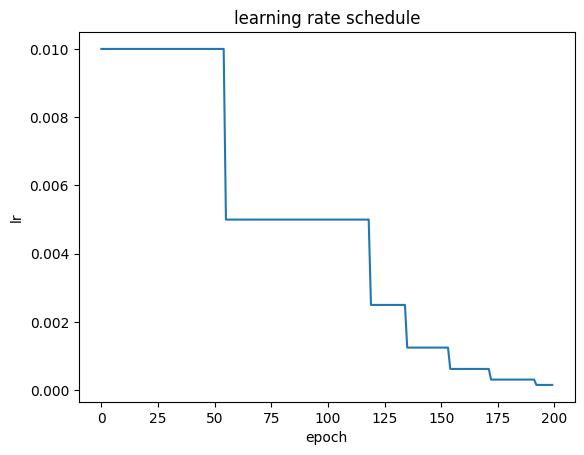

In [ ]:
plt.plot(lr_list)

plt.title('learning rate schedule')
plt.xlabel('epoch')
plt.ylabel('lr')

Text(0, 0.5, 'accuracy')

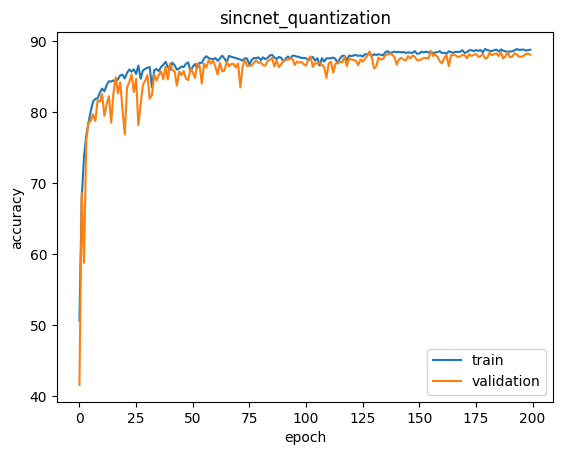

In [ ]:
plt.plot(train_acc_list)
plt.plot(val_acc_list)
plt.legend(labels=["train", "validation"],loc=0)


plt.title('sincnet_quantization')
plt.xlabel('epoch')
plt.ylabel('accuracy')